# Overview
Dataset from: https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset

### Introduction
There are a few methods that I intend to employ within this data. Given that there are only 8 features, there is not much dimensionality within the data. Therefore, more complex models such as neural networks may not be needed.

### Methods Selection
As such, the following will more than likely be enough to properly synthesize appropriate results:
- Logistic Regression: Will allow more interpretable results.
- Random Forest/Decision Tree: While the Random Forest may be more accurate, I will utilize both approaches, since these both do well with problems that have a feature count similar to this problem.
- Support Vector Machine: Works well with non-linear relationships, which may be found within this data.
- Neural Networks: Even though I state this may be overkill, I will test a few networks to see how well they perform to learn how to regulate over- and under-fitting.

I will also be employing other methods, such as:
- Gradient Boosting (XGBoost): May combine this with techniques to see if there is a data imbalance (I.e. SMOTE & ADASYN)

## Imports

In [12]:
import os
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Custom Imports

In [13]:
from scripts.logistic import Logistic

## Custom Variables

In [14]:
skip_graphs = False
run_logistic = False

## Initialize Data

In [15]:
# Download latest version
path = kagglehub.dataset_download("akshaydattatraykhare/diabetes-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Brendito\.cache\kagglehub\datasets\akshaydattatraykhare\diabetes-dataset\versions\1


In [16]:
# Load the CSV file into a pandas DataFrame
csv_file_path = os.path.join(path, "diabetes.csv")  # Replace "diabetes.csv" with the actual file name
df = pd.read_csv(csv_file_path)

# Get the Length of the DataFrame
print("Length of df:", len(df))

Length of df: 768


## Preprocessing of Data

In [17]:
# Define the columns to check for zero values
columns_to_check = ["Glucose", "SkinThickness", "BloodPressure", "Insulin", "BMI"]

# Replace zero values in the specified columns with -1
df[columns_to_check] = df[columns_to_check].replace(0, -1)

# Name Changes
name_changes = {"BloodPressure": "Blood Pressure", "SkinThickness": "Skin Thickness", "DiabetesPedigreeFunction": "Diabetes Pedigree Function", "BMI": "Body Mass Index", "Age": "Age", "Glucose": "Glucose", "Insulin": "Insulin", "Pregnancies": "Pregnancies"}
# Rename the columns in the DataFrame
df.rename(columns=name_changes, inplace=True)


## Data Examination

In [18]:
print(df.head())  # Display the first few rows of the DataFrame

   Pregnancies  Glucose  Blood Pressure  Skin Thickness  Insulin  \
0            6      148              72              35       -1   
1            1       85              66              29       -1   
2            8      183              64              -1       -1   
3            1       89              66              23       94   
4            0      137              40              35      168   

   Body Mass Index  Diabetes Pedigree Function  Age  Outcome  
0             33.6                       0.627   50        1  
1             26.6                       0.351   31        0  
2             23.3                       0.672   32        1  
3             28.1                       0.167   21        0  
4             43.1                       2.288   33        1  


In [23]:
# Create empty DataFrame to store statistics
columns = ['Count', 'Mean', 'Std', 'Min', '5%', '25%', 'Median', '75%', '95%', 'Max']
stats_df = pd.DataFrame(index=df.columns, columns=columns)

# Calculate statistics for each column
for column in df.columns:
    # Filter out the -1 values
    filtered_data = df[df[column] != -1][column]
    
    # Places to round to
    round_to = 3
    
    # Calculate statistics
    stats_df.loc[column, 'Count'] = filtered_data.count()
    stats_df.loc[column, 'Mean'] = round(filtered_data.mean(), round_to)
    stats_df.loc[column, 'Std'] = round(filtered_data.std(), round_to)
    stats_df.loc[column, 'Min'] = round(filtered_data.min(), round_to)
    stats_df.loc[column, '5%'] = round(filtered_data.quantile(0.05), round_to)
    stats_df.loc[column, '25%'] = round(filtered_data.quantile(0.25), round_to)
    stats_df.loc[column, 'Median'] = round(filtered_data.median(), round_to)
    stats_df.loc[column, '75%'] = round(filtered_data.quantile(0.75), round_to)
    stats_df.loc[column, '95%'] = round(filtered_data.quantile(0.95), round_to)
    stats_df.loc[column, 'Max'] = round(filtered_data.max(), round_to)

print(", ".join(f'"{column}"' for column in df.columns))

print(stats_df)

# Round to 2 decimal places and save as csv
stats_df.to_csv("data/diabetes_stats.csv")

"Pregnancies", "Glucose", "Blood Pressure", "Skin Thickness", "Insulin", "Body Mass Index", "Diabetes Pedigree Function", "Age", "Outcome"
                           Count     Mean      Std    Min     5%    25%  \
Pregnancies                  768    3.845     3.37      0    0.0    1.0   
Glucose                      763  121.687   30.536     44   80.0   99.0   
Blood Pressure               733   72.405   12.382     24   52.0   64.0   
Skin Thickness               541   29.153   10.477      7   13.0   22.0   
Insulin                      394  155.548  118.776     14  41.65  76.25   
Body Mass Index              757   32.457    6.925   18.2   22.2   27.5   
Diabetes Pedigree Function   768    0.472    0.331  0.078   0.14  0.244   
Age                          768   33.241    11.76     21   21.0   24.0   
Outcome                      768    0.349    0.477      0    0.0    0.0   

                           Median    75%    95%   Max  
Pregnancies                   3.0    6.0   10.0    17 

### Graphs

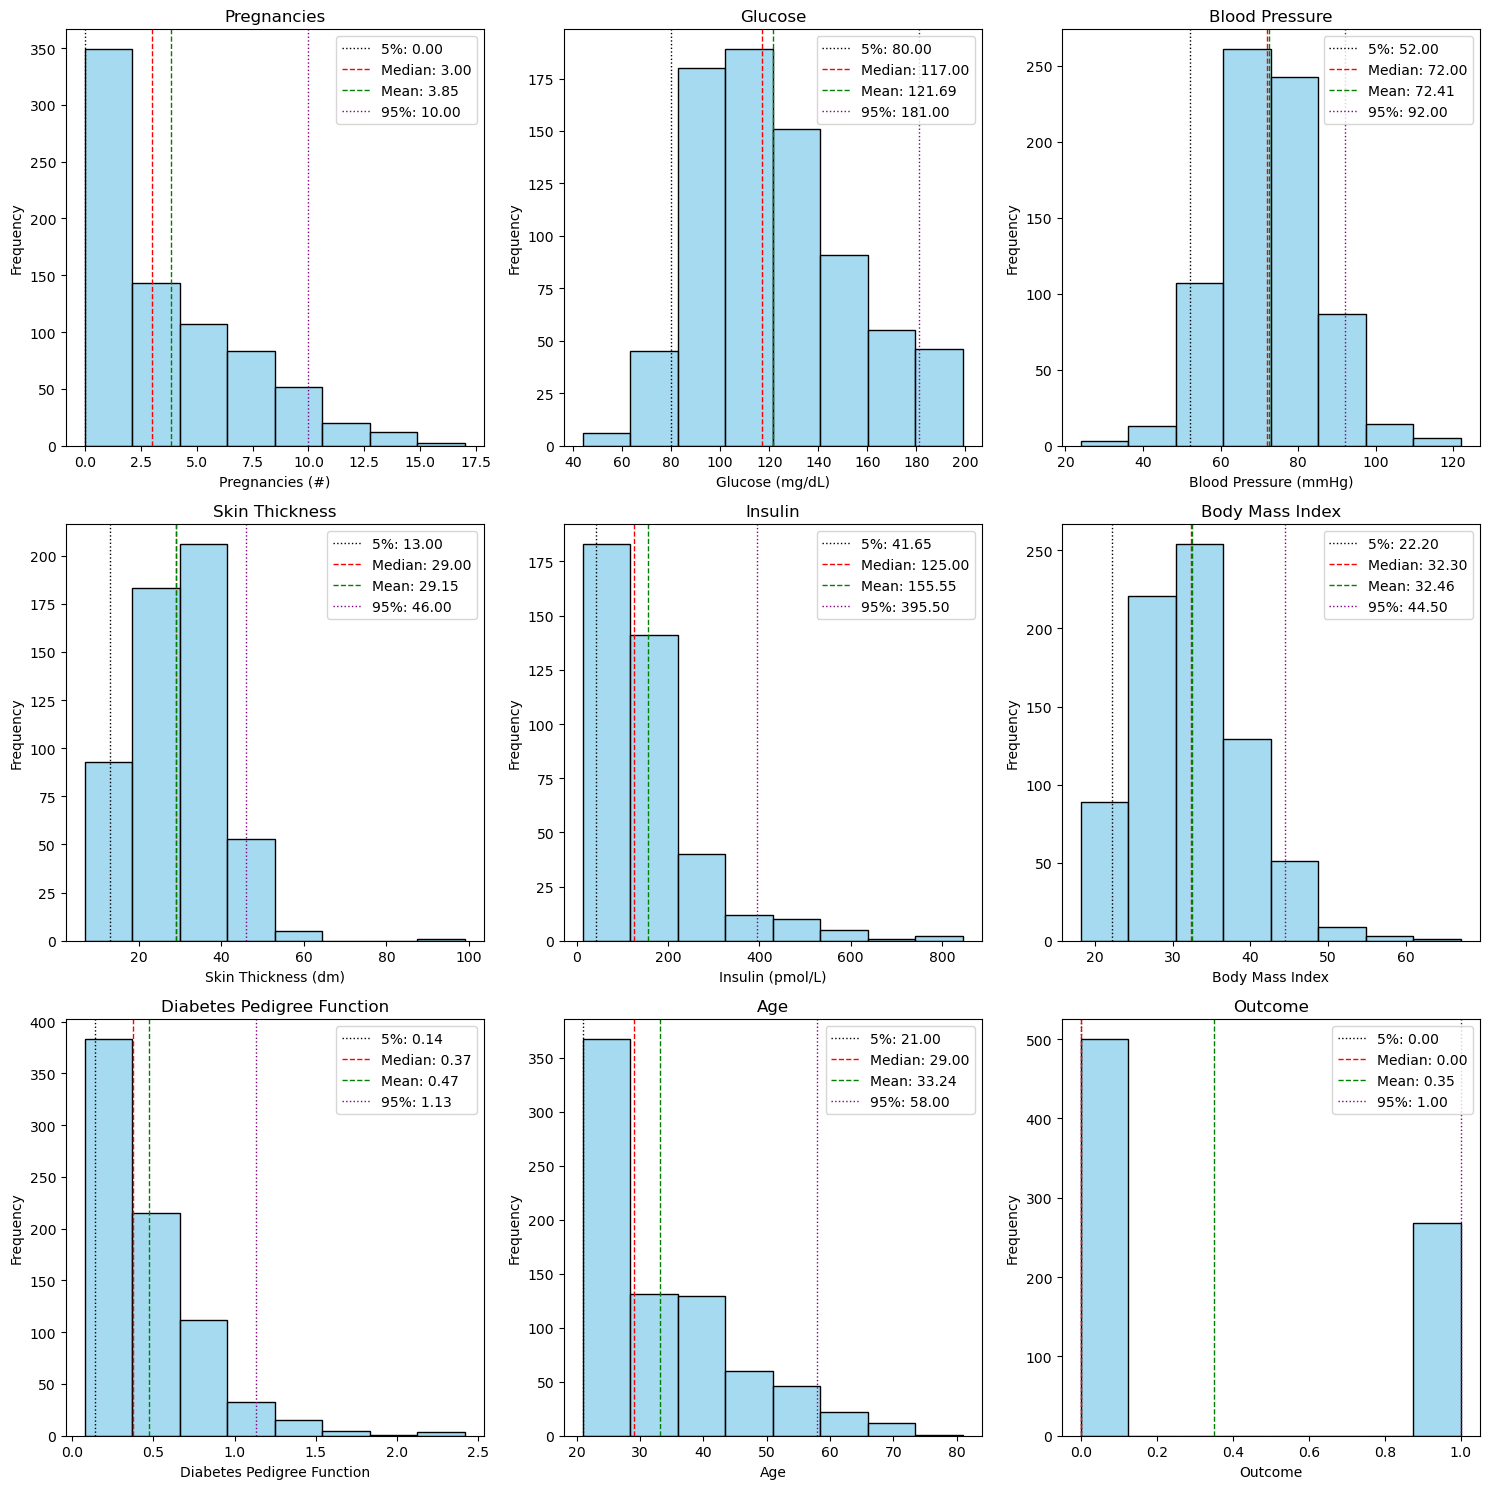

In [20]:
if not skip_graphs:
    # Create a 3x3 grid of histograms using Seaborn
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.ravel()  # Flatten the 3x3 array of axes for easier iteration

    # Dictionary of Name Changes
    x_labels = {"Blood Pressure": "Blood Pressure (mmHg)", "Skin Thickness": "Skin Thickness (dm)", "Diabetes Pedigree Function": "Diabetes Pedigree Function", "Body Mass Index": "Body Mass Index", "Age": "Age", "Glucose": "Glucose (mg/dL)", "Insulin": "Insulin (pmol/L)", "Pregnancies": "Pregnancies (#)"}

    # Plot each column in the DataFrame
    for i, column in enumerate(df.columns):
        # Filter out values that are -1
        filtered_data = df[df[column] != -1][column]
        
        # Create histogram without KDE line
        sns.histplot(data=filtered_data, bins=8, kde=False, ax=axes[i], color='skyblue', edgecolor='black')
        
        # Add statistical markers
        median = filtered_data.median()
        q1 = filtered_data.quantile(0.05)
        q3 = filtered_data.quantile(0.95)
        mean = filtered_data.mean()
        axes[i].axvline(q1, color='black', linestyle='dotted', linewidth=1, label=f'5%: {q1:.2f}')
        axes[i].axvline(median, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median:.2f}')
        axes[i].axvline(mean, color='green', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.2f}')
        axes[i].axvline(q3, color='purple', linestyle='dotted', linewidth=1, label=f'95%: {q3:.2f}')
        
        # Set titles and labels
        title = f"{name_changes.get(column, column)}"
        axes[i].set_title(title)
        axes[i].set_xlabel(x_labels.get(column, column))
        axes[i].set_ylabel('Frequency')
        axes[i].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.savefig('./images/histograms.png', bbox_inches='tight')
    plt.show()
else:
    print("Skipping Graphs since skip_graphs is set to True")

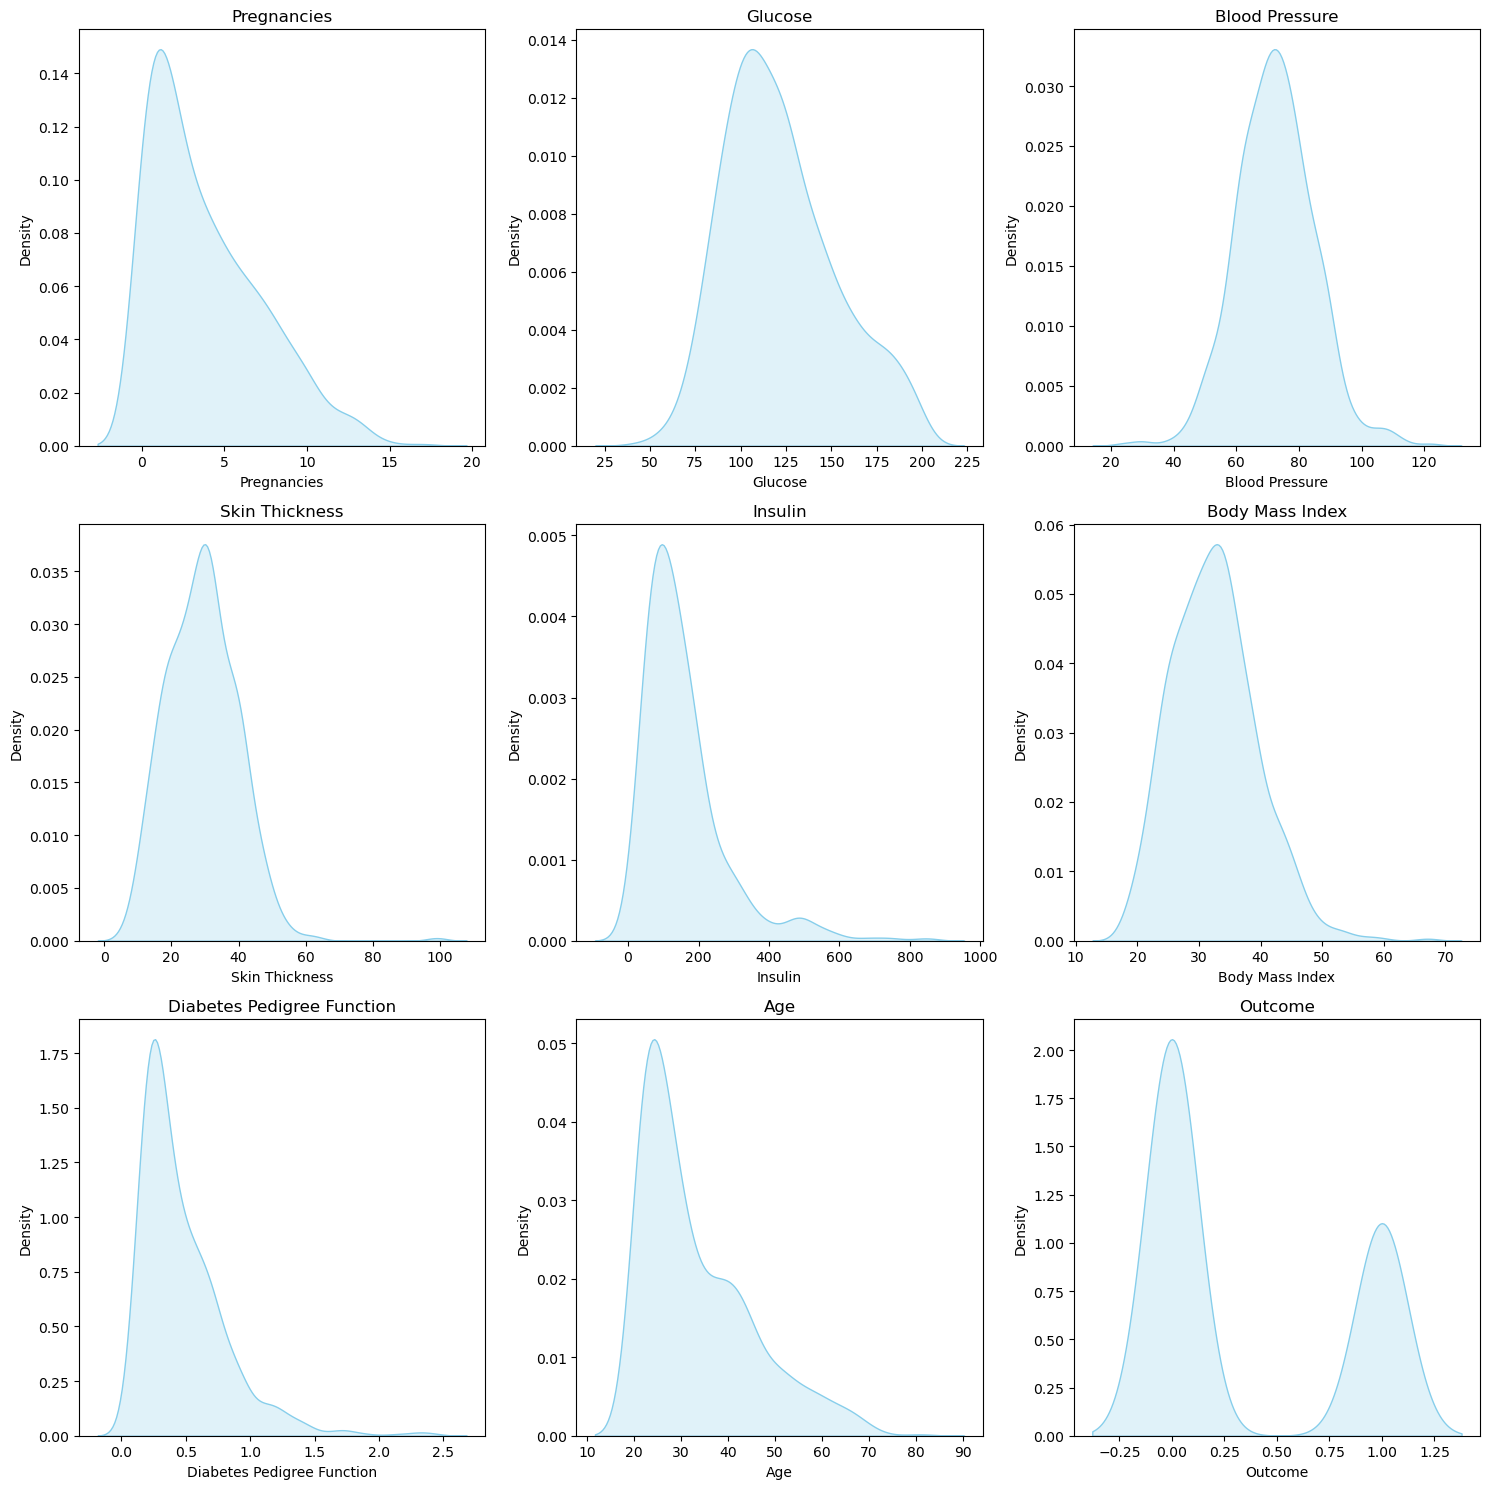

In [21]:
if not skip_graphs:
    # Create a 3x3 grid for KDE plots
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.ravel()  # Flatten the 3x3 array of axes for easier iteration
    
    # Plot KDE for each column
    for i, column in enumerate(df.columns):
        # Filter out values that are -1
        filtered_data = df[df[column] != -1][column]
        sns.kdeplot(data=filtered_data, ax=axes[i], fill=True, color='skyblue', bw_adjust=1, label='KDE')
        axes[i].set_title(f"{name_changes.get(column, column)}")
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Density')
        # axes[i].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.savefig('./images/kde.png', bbox_inches='tight')
    plt.show()
else:
    print("Skipping Graphs since skip_graphs is set to True")

## Logistic Regression

In [22]:
if run_logistic:
    models_logistic = [
        Logistic(penalty="l1"),
        Logistic(penalty="l2"),
        Logistic(penalty="elasticnet")
    ]

    names = ["L1", "L2", "Elasticnet"]

    for model, name in zip(models_logistic, names):
        # Print Name of Current Run.
        print(f"Running {name}...")
        
        # Get the Train, Test Sets
        X_train, X_test, y_train, y_test = model.split_train_test(df)
        
        # Run the model
        results = model.train_and_evaluate(X_train, X_test, y_train, y_test)
        print(results)
        
        # Save results to CSV
        results.to_csv(f"logistic_{name}_results.csv")
else:
    print("Skipping Logistic Regression since run_logistic is set to False")

Skipping Logistic Regression since run_logistic is set to False
